In [1]:
# Load in the packages
import numpy as np
import folktables
from folktables import ACSDataSource, ACSIncome

import os
import sys
import copy
sys.path.append('..')
import random
import FairCertModule
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import models, transforms
from FullyConnected import FullyConnected
import pytorch_lightning as pl

# Set random seeds
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

dataset = "Folk"
if(dataset == "Coverage"):
    TEST_EPSILON = 0.15
else:
    TEST_EPSILON = 0.05   


In [2]:
# Data loaders
import folk_utils
X_train, X_test, X_val, y_train, y_test, y_val, lp_epsilon, sr_epsilon = folk_utils.get_dataset(dataset)
f_epsilon = lp_epsilon

/Users/matthewwicker/opt/anaconda3/envs/FairnessEnv/lib/python3.7/site-packages/sklearn/decomposition/_truncated_svd.py:234: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


In [3]:
# Load in the trained models

MODEL_STATE  = 'CA'
MODEL_YEAR   = '2015'
MODEL_WIDTH  = '256'
MODEL_METRIC = 'LP'

sgd_id = "Toy" 
#pgd_id = "FAIR-PGD" 
##ibp_id = "FAIR-IBP" 
#glob_id = "FAIR-DRO"
ibpg_id = "FAIR-IBPG"

def load_model_from_id(model_id, dataset, width=MODEL_WIDTH):
    if(model_id == "Toy"):
        model = FullyConnected(hidden_lay=2, hidden_dim=16, dataset=dataset)
    else:
        model = FullyConnected(hidden_lay=2, hidden_dim=256, dataset=dataset)
    ckpt = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    checkpoint = torch.load("%sModels/%s.ckpt"%(dataset, model_id))
    model.load_state_dict(torch.load('%sModels/%s.pt'%(dataset, model_id)))
    return model

toy_model = load_model_from_id(sgd_id, dataset)
#pgd_model = load_model_from_id(pgd_id, dataset)
#ibp_model = load_model_from_id(ibp_id, dataset)
#glob_model = load_model_from_id(glob_id, dataset)
ibpg_model = load_model_from_id(ibpg_id, dataset)


In [4]:
def form_lp(model, c, initial_bounds, bounds):
    """
    https://adversarial-ml-tutorial.org/adversarial_examples/
    """
    linear_layers = [(layer, bound) for layer, bound in zip(model.lays,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i]),
                        v[i] >= 0,
                        v[i] <= 1]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    
    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

import cvxpy as cp

def form_milp(model, c, initial_bounds, bounds, maximize=True):
    linear_layers = [(layer, bound) for layer, bound in zip(model.lays,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features, boolean=True) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i])]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    if(maximize):
        return cp.Problem(cp.Maximize(c @ z[d+1]), constraints), (z, v)
    else:
        return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    
    for layer in model.lays:
        #if isinstance(layer, nn.Linear):
        #    l_ = (layer.weight.clamp(min=0).float() @ l.t().float() + layer.weight.clamp(max=0).float() @ u.t().float() 
        #          + layer.bias[:,None]).t().float()
        #    u_ = (layer.weight.clamp(min=0) @ u.t().float() + layer.weight.clamp(max=0).float() @ l.t().float() 
        #          + layer.bias[:,None]).t().float()
        if isinstance(layer, nn.Linear):
            x_mu = ((u + l) / 2).float()
            x_r = ((u - l) / 2).float()
            h_mu = torch.matmul(x_mu, layer.weight.T.float())
            x_rad = torch.matmul(x_r, torch.abs(layer.weight).T.float())
            u_ = h_mu + x_rad + layer.bias.float()
            l_ = h_mu - x_rad + layer.bias.float()
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

In [5]:
INDEX = 100
c = np.zeros(2)
c[1] = 1
c[0] = 1

initial_bound = ((X_test[INDEX:INDEX+1] - (f_epsilon*0.15)), (X_test[INDEX:INDEX+1] + (f_epsilon*0.15)))
bounds = bound_propagation(toy_model, initial_bound)





In [6]:
initial_bound = ((X_test[INDEX:INDEX+1] - (f_epsilon*0.15)), (X_test[INDEX:INDEX+1] + (f_epsilon*0.15)))
bounds = bound_propagation(toy_model, initial_bound)
prob, (z, v) = form_milp(toy_model, c, initial_bound, bounds, maximize=True)
print("Objective value:", prob.solve(solver=cp.CPLEX))
print("Last layer from relaxation:", z[-1].value)


Objective value: -0.024812125140435792
Last layer from relaxation: [ 0.2502784  -0.27509053]


In [7]:
initial_bound = ((X_test[INDEX:INDEX+1] - (f_epsilon*0.0)), (X_test[INDEX:INDEX+1] + (f_epsilon*0.0)))
bounds = bound_propagation(toy_model, initial_bound)

bounds = bound_propagation(ibpg_model, initial_bound)
print(bounds[-1])
prob, (z, v) = form_milp(ibpg_model, c, initial_bound, bounds, maximize=True)
print("Objective value:", prob.solve(solver=cp.GLPK_MI))
print("Last layer from relaxation:", z[-1].value)

prob, (z, v) = form_milp(ibpg_model, c, initial_bound, bounds, maximize=False)
print("Objective value:", prob.solve(solver=cp.GLPK_MI))
print("Last layer from relaxation:", z[-1].value)

(tensor([[-1.4584,  1.5563]], grad_fn=<AddBackward0>), tensor([[-1.4584,  1.5563]], grad_fn=<AddBackward0>))
Objective value: -inf
Last layer from relaxation: None
Objective value: inf
Last layer from relaxation: None


In [8]:
initial_bound = ((X_test[INDEX:INDEX+1] - (f_epsilon*0.0)), (X_test[INDEX:INDEX+1] + (f_epsilon*0.0)))
bounds = bound_propagation(ibpg_model, initial_bound)
print(bounds[-1])
prob, (z, v) = form_milp(ibpg_model, c, initial_bound, bounds)
print("Objective value:", prob.solve(solver=cp.GLPK_MI))
print("Last layer from relaxation:", z[-1].value)

(tensor([[-1.4584,  1.5563]], grad_fn=<AddBackward0>), tensor([[-1.4584,  1.5563]], grad_fn=<AddBackward0>))
Objective value: -inf
Last layer from relaxation: None


In [9]:
from folk_utils import I
INDEX = 21
values = []
for eps in np.linspace(0.05, 1, 100):
    v = I(ibpg_model, X_test[INDEX:INDEX+1].float(), y_test[INDEX:INDEX+1].long(), f_epsilon, eps, 2)
    values.append(float(v.detach().numpy()))
print(v)

tensor([0.0451], grad_fn=<MeanBackward1>)


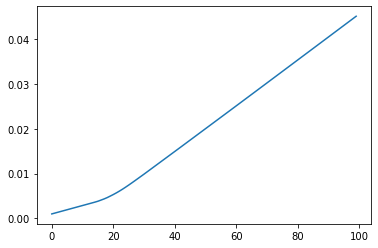

In [10]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(values)
plt.show()

In [11]:
from folk_utils import I
from tqdm import trange
def g(val, index=0):
    return I(ibpg_model, X_test[INDEX:INDEX+1].float(), y_test[INDEX:INDEX+1].long(), f_epsilon, val, 2)

#𝑔(𝜆𝑥+(1−𝜆)𝑦)≤𝜆𝑔(𝑥)+(1−𝜆)𝑔(𝑦)
def check_convexity(index):
    x=0.05
    y=1.00
    for lam in np.linspace(0.05, 1, 10):
        #print(lam*x + ((1-lam)*y))
        value = (g(lam*x + ((1-lam)*y), index=index) <= lam*g(x, index=index) + (1-lam)*g(y, index=index) )
        if(value == False):
            return False
    return True

for i in trange(1000):
    assert(check_convexity(i))

  3%|██                                                                        | 28/1000 [00:06<03:47,  4.27it/s]

KeyboardInterrupt



In [27]:
from folk_utils import compute_DIF_certification
val, trend = compute_DIF_certification(ibpg_model, f_epsilon, 0.1, 0.025, 
                                       X_test, y_test, N=100, iters=1000, rettrend=True, lr = 1.0)




100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 253.55it/s]


tensor(0.0287, grad_fn=<MeanBackward0>)


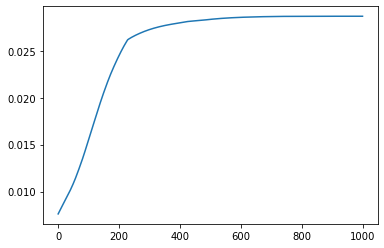

In [28]:
plt.plot(trend)
print(val)
plt.show()